# Useful tips

The API documentation does not give credits to some useful features find in prose. Here is a non exausthive demonstartion of some of them:

- [Accessing blocks](#Accessing-blocks)
- [Plotting in Sequence](#Plotting-in-Sequence)

In what follows we will make examples from a random set of images

In [48]:
import numpy as np
from prose import Image, Sequence

np.random.seed(42)
images = [Image(data=np.random.randn(100,100)) for i in range(5)]

## Accessing blocks

When a `Sequence` is defined there are few ways to access its blocks. Let's define one for example

In [59]:
from prose.blocks import Set, Pass, SegmentedPeaks

sequence = Sequence([
    Pass(name="named_block"),
    Set(example=True),
    SegmentedPeaks(),
], images)

The list of blocks is returned by

In [57]:
sequence.blocks

but specific blocks can also be accessed by name (if they have one) 

In [61]:
sequence.named_block

## Plotting in Sequence

The `Plot` `Block` can be used to record any plotting function applied to an `Image`, like

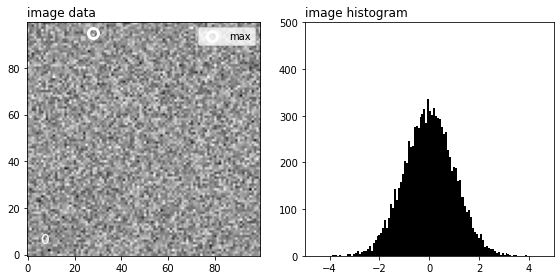

In [63]:
import matplotlib.pyplot as plt

# This function plot the image, its max and an histogram of it
def show(image):
    plt.figure(figsize=(8,4))
    plt.subplot(121)
    plt.title("image data", loc="left")
    plt.imshow(image.data, origin="lower", cmap="Greys")
    plt.plot(*np.unravel_index(np.argmax(image.data), image.data.shape), "o", 
             ms=10, fillstyle="none", c="w", markeredgewidth=3, label="max")
    plt.text(5, 5, image.i if hasattr(image, "i") else "--", color="white", fontsize=14)
    plt.legend()
    
    plt.subplot(122)
    plt.hist(image.data.flatten(), bins=100, color="k")
    plt.xlim(-5, 5)
    plt.ylim(0, 500)
    plt.title("image histogram", loc="left")
    plt.tight_layout()
    
# for example
show(images[0])

This can be used within a `Sequence` through the use of `Plot` to create a video/gif of it

In [64]:
from prose.blocks import Plot

# we define our block
plot_block = Plot(show, "plots.gif")

# adding to the sequence and running
sequence = Sequence([plot_block], images)
sequence.run()

RUN default: 100%|████████████████████████████| 5/5 [00:01<00:00,  2.90images/s]


![](plots.gif)